In [4]:
!wget https://kot-pes.com/wp-content/uploads/2019/02/post_5c606e629f934.jpg

--2024-03-25 15:21:18--  https://kot-pes.com/wp-content/uploads/2019/02/post_5c606e629f934.jpg
Resolving kot-pes.com (kot-pes.com)... 104.21.1.198, 172.67.129.225, 2606:4700:3031::ac43:81e1, ...
Connecting to kot-pes.com (kot-pes.com)|104.21.1.198|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 161127 (157K) [image/jpeg]
Saving to: ‘post_5c606e629f934.jpg’

post_5c606e629f934. 100%[===================>] 157.35K  55.4KB/s    in 2.8s    

2024-03-25 15:21:24 (55.4 KB/s) - ‘post_5c606e629f934.jpg’ saved [161127/161127]



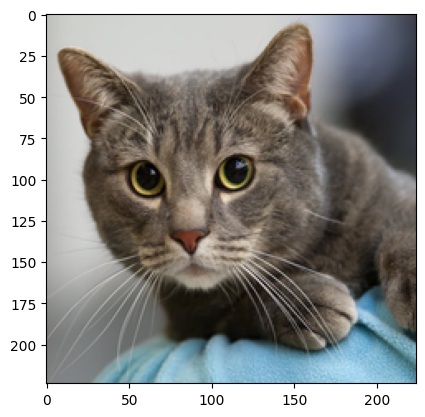

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
img = np.array(Image.open('post_5c606e629f934.jpg').resize((300,224),Image.LANCZOS))[:,20:224+20]
plt.imshow(img)

In [6]:
from tensorflow import keras

vgg = keras.applications.VGG16()

553467096/553467096 [==============================] - 24s 0us/step


In [12]:
res = vgg.predict(np.expand_dims(keras.applications.vgg16.preprocess_input(img),0))
keras.applications.vgg16.decode_predictions(res)

1/1 [==============================] - 0s 152ms/step


[[('n02123045', 'tabby', 0.47968382),
  ('n02124075', 'Egyptian_cat', 0.26547003),
  ('n02123159', 'tiger_cat', 0.068180814),
  ('n02883205', 'bow_tie', 0.034341976),
  ('n02127052', 'lynx', 0.011416406)]]

In [13]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [19]:
fltrz = vgg.layers[1].weights[0]
fltrz.shape

TensorShape([3, 3, 3, 64])

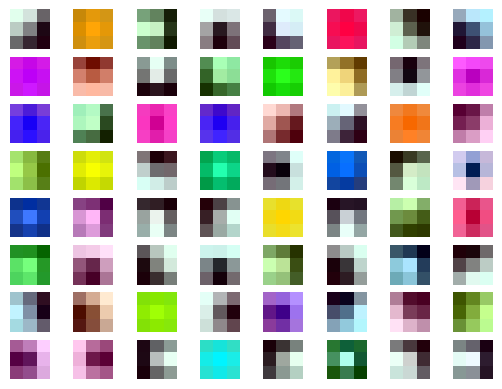

In [24]:
import tensorflow as tf

def norm(x):
  xmi = tf.reduce_min(x)
  xma = tf.reduce_max(x)
  return (x-xmi)/(xma-xmi)

fig,ax = plt.subplots(8,8)
for i in range(8):
  for j in range(8):
    ax[i,j].imshow(norm(fltrz[...,i*8+j]))
    ax[i,j].axis('off')

In [26]:
vmodel = keras.models.Model(vgg.input,vgg.get_layer('block1_conv1').output)
im = np.expand_dims(keras.applications.vgg16.preprocess_input(img),0)
res = vmodel(im)[0]
res.shape

TensorShape([224, 224, 64])

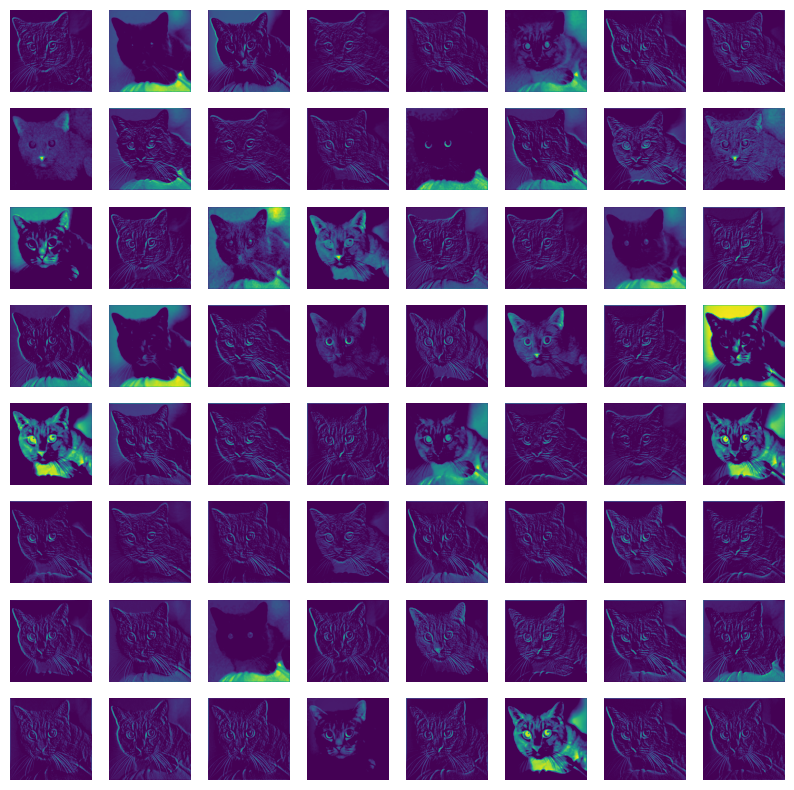

In [29]:
fig,ax = plt.subplots(8,8,figsize=(10,10))
for i in range(8):
  for j in range(8):
    ax[i,j].imshow(norm(res[...,i*8+j]))
    ax[i,j].axis('off')

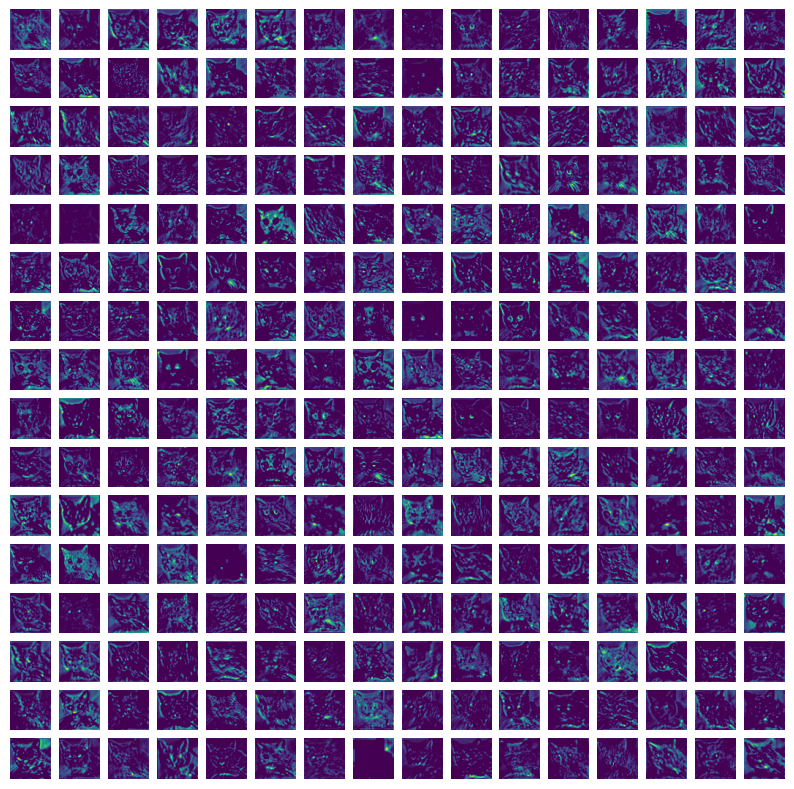

In [33]:
vmodel = keras.models.Model(vgg.input,vgg.get_layer('block3_conv2').output)
res = vmodel(im)[0]
fig,ax = plt.subplots(16,16,figsize=(10,10))
z = norm(res)
for i in range(16):
  for j in range(16):
    ax[i,j].imshow(z[...,i*16+j])
    ax[i,j].axis('off')

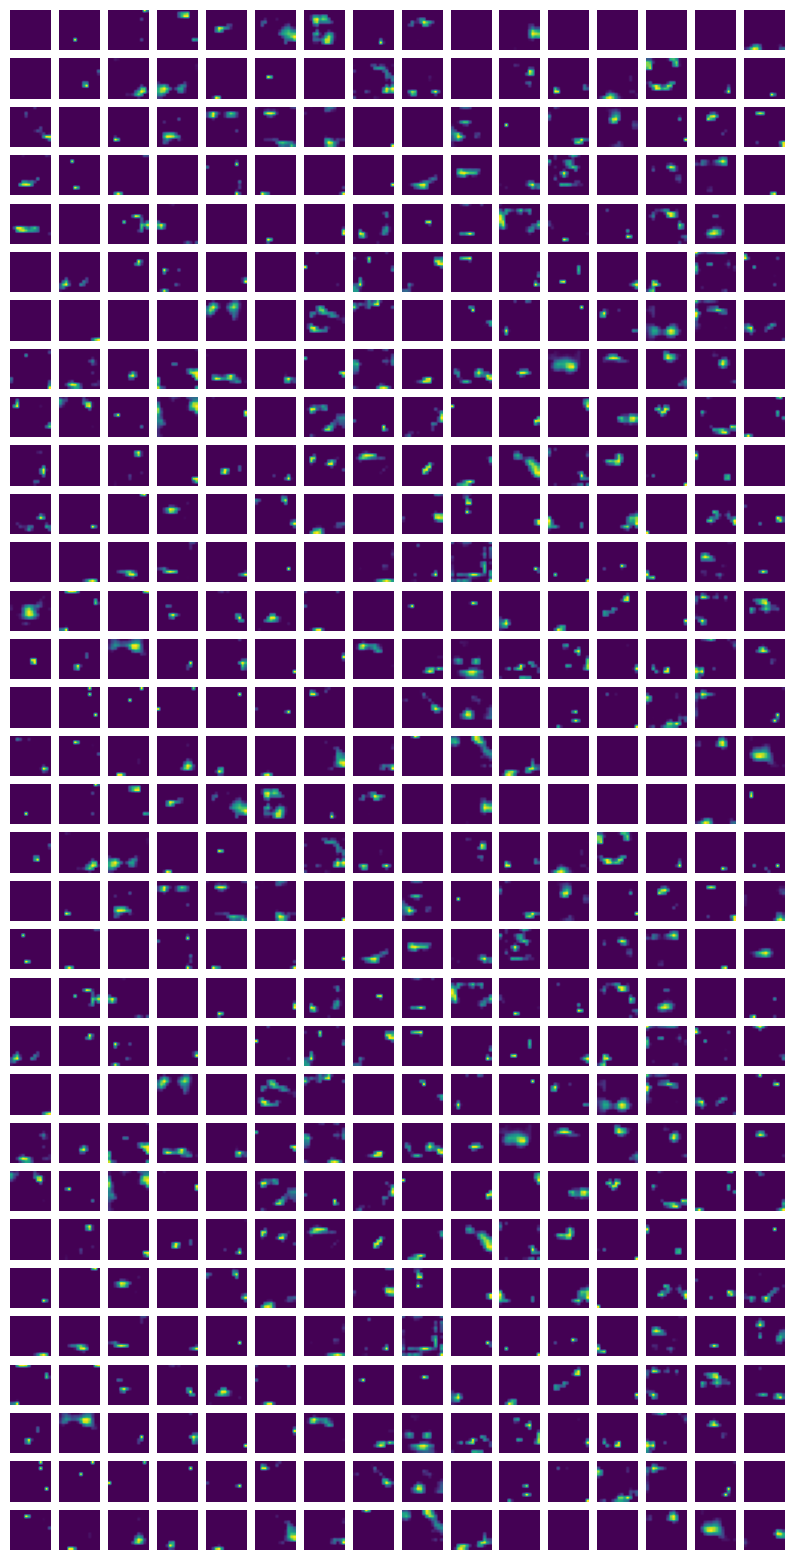

In [39]:
vmodel = keras.models.Model(vgg.input,vgg.get_layer('block5_conv3').output)
res = vmodel(im)[0]
fig,ax = plt.subplots(32,16,figsize=(10,20))
z = norm(res)
for i in range(32):
  for j in range(16):
    ax[i,j].imshow(z[...,j*16+i])
    ax[i,j].axis('off')

## GradCam

(-0.5, 223.5, 223.5, -0.5)

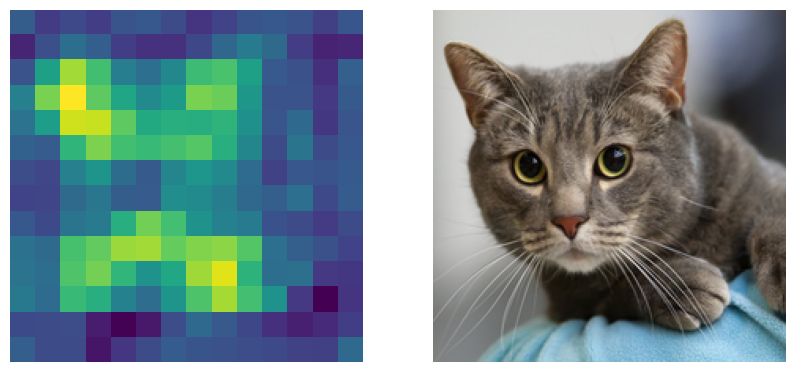

In [43]:
vgg.layers[-1].activation = None # удаляем softmax
grad_model = keras.models.Model(
        vgg.inputs, [vgg.get_layer('block5_conv3').output, vgg.output])

with tf.GradientTape() as tape:
    last_conv_layer_output, preds = grad_model(im)
    pred_index = tf.argmax(preds[0]) # можно задать любой другой класс для визуализации
    class_channel = preds[:, pred_index]
    grads = tape.gradient(class_channel, last_conv_layer_output)

pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
last_conv_layer_output = last_conv_layer_output[0]
heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
heatmap = tf.squeeze(heatmap)

fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(norm(heatmap))
ax[1].imshow(img)
ax[0].axis('off')
ax[1].axis('off')

Визуализация GradCam в [тьюториале Keras](https://keras.io/examples/vision/grad_cam/)

## Ideal Cat

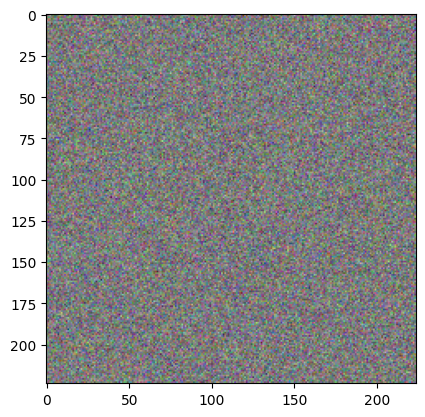

1/1 [==============================] - 0s 200ms/step


[[('n03788365', 'mosquito_net', 0.057171844),
  ('n03291819', 'envelope', 0.022203308),
  ('n15075141', 'toilet_tissue', 0.016988626),
  ('n04209239', 'shower_curtain', 0.014572884),
  ('n07248320', 'book_jacket', 0.01110648)]]

In [54]:
x = tf.Variable(tf.random.normal((1,224,224,3)))
model = keras.applications.VGG16()
plt.imshow(norm(x)[0])
plt.show()
keras.applications.vgg16.decode_predictions(model.predict(x))


In [49]:
from IPython.display import clear_output


target = [284] # Siamese cat

def cross_entropy_loss(target,res):
    return tf.reduce_mean(keras.metrics.sparse_categorical_crossentropy(target,res))

def optimize(x,target,epochs=1000,show_every=None,loss_fn=cross_entropy_loss, eta=1.0):
    if show_every is None:
        show_every = epochs // 10
    for i in range(epochs):
        with tf.GradientTape() as t:
            res = model(x)
            loss = loss_fn(target,res)
            grads = t.gradient(loss,x)
            x.assign_sub(eta*grads)
            if i%show_every == 0:
                clear_output(wait=True)
                print(f"Epoch: {i}, loss: {loss}")
                plt.imshow(norm(x[0]))
                plt.show()

Epoch: 900, loss: 0.7263923287391663


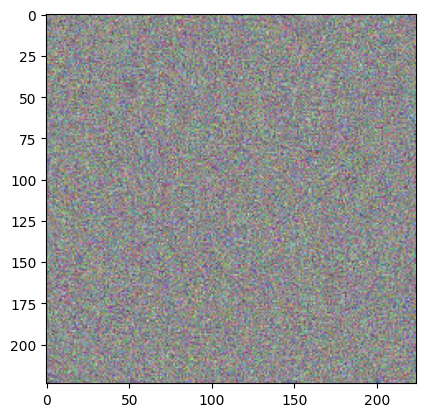

In [50]:
optimize(x,target)

In [51]:
keras.applications.vgg16.decode_predictions(model.predict(x))

1/1 [==============================] - 0s 138ms/step


[[('n02123597', 'Siamese_cat', 0.5414602),
  ('n02111889', 'Samoyed', 0.022925839),
  ('n02099849', 'Chesapeake_Bay_retriever', 0.014964517),
  ('n02120079', 'Arctic_fox', 0.014689954),
  ('n02443484', 'black-footed_ferret', 0.014316017)]]

Epoch: 900, loss: [69.95975]


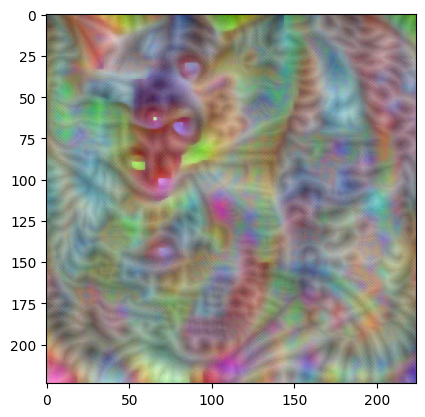

In [61]:
def total_loss(target,res):
    return 10*tf.reduce_mean(keras.metrics.sparse_categorical_crossentropy(target,res)) + \
           0.008*tf.image.total_variation(x,res)

x = tf.Variable(tf.random.normal((1,224,224,3)))
optimize(x,[284],loss_fn=total_loss)

In [62]:
keras.applications.vgg16.decode_predictions(model.predict(x))

1/1 [==============================] - 0s 10ms/step


[[('n02123597', 'Siamese_cat', 0.91736245),
  ('n02443484', 'black-footed_ferret', 0.004008722),
  ('n02342885', 'hamster', 0.0035891365),
  ('n02441942', 'weasel', 0.0035089962),
  ('n02085620', 'Chihuahua', 0.0033064452)]]

(-0.5, 223.5, 223.5, -0.5)

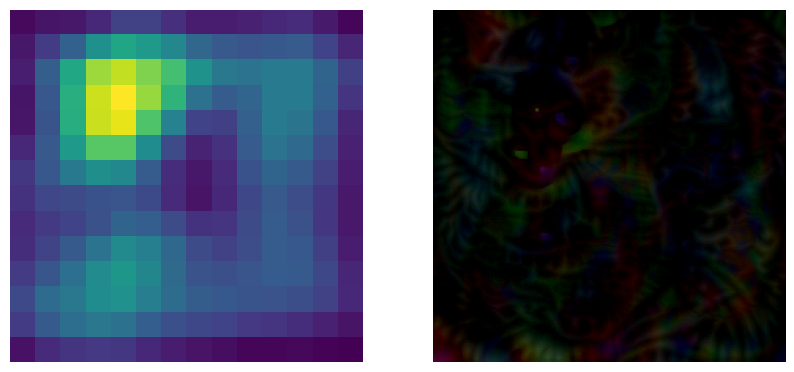

In [63]:
vgg.layers[-1].activation = None # удаляем softmax
grad_model = keras.models.Model(
        vgg.inputs, [vgg.get_layer('block5_conv3').output, vgg.output])

with tf.GradientTape() as tape:
    last_conv_layer_output, preds = grad_model(x)
    pred_index = tf.argmax(preds[0]) # можно задать любой другой класс для визуализации
    class_channel = preds[:, pred_index]
    grads = tape.gradient(class_channel, last_conv_layer_output)

pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
last_conv_layer_output = last_conv_layer_output[0]
heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
heatmap = tf.squeeze(heatmap)

fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(norm(heatmap))
ax[1].imshow(x[0])
ax[0].axis('off')
ax[1].axis('off')

Epoch: 900, loss: 0.2330084592103958


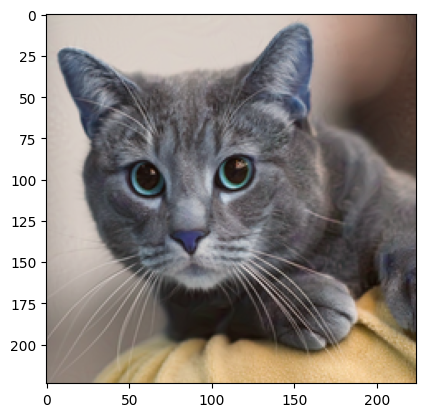

1/1 [==============================] - 0s 8ms/step


[[('n02088364', 'beagle', 0.8186348),
  ('n02088238', 'basset', 0.034242045),
  ('n02092339', 'Weimaraner', 0.026590982),
  ('n02124075', 'Egyptian_cat', 0.011279412),
  ('n02085620', 'Chihuahua', 0.008708577)]]

In [69]:
#x = tf.Variable(im.copy())
optimize(x,[162],eta=20.0)
keras.applications.vgg16.decode_predictions(model.predict(x))

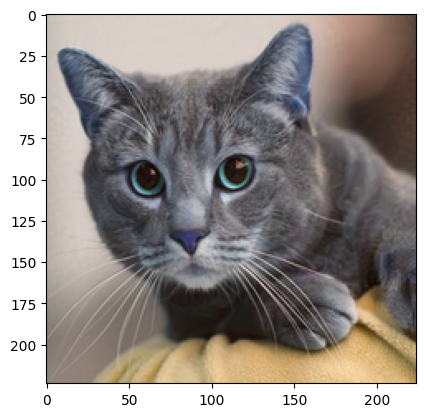

In [71]:
plt.imshow(norm(x[0]))

In [ ]:
tf.reduce_max((im-x)[0])

In [ ]:
plt.imshow(((im-x)[0])/25.+0.5)